In [7]:
from dataclasses import dataclass

@dataclass
class ImgRec:
    """Image file record with metadata"""

    path: str
    size: int
    mtime: float

In [12]:
import os

def scan_images(folder):
    img_exts = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}
    records = []
    for root, _, files in os.walk(folder):
        for file in files:
            ext = os.path.splitext(file)[1].lower()
            if ext in img_exts:
                path = os.path.join(root, file)
                stat = os.stat(path)
                records.append(ImgRec(path=path, size=stat.st_size, mtime=stat.st_mtime))
    return records

# Example usage:
images1 = scan_images('images/examples2')
images1

[ImgRec(path='images/examples2/object_6_381_7f54c865-52fa-4b30-bca8-40ff4043255d.jpeg', size=17374, mtime=1760500967.1952114),
 ImgRec(path='images/examples2/object_6_378_2f935621-b60b-411b-a78b-9e6a14d90c8b.jpeg', size=19566, mtime=1760500967.991225),
 ImgRec(path='images/examples2/object_6_383_f47c3610-c129-4d90-9664-ebd42d7e08a2.jpeg', size=16490, mtime=1760500966.357197),
 ImgRec(path='images/examples2/object_6_379_891d0c67-f72a-4f97-971c-bff1efa3822a.jpeg', size=18993, mtime=1760500967.6062183),
 ImgRec(path='images/examples2/object_6_382_8158808b-eeaf-4133-8ed1-6024c775438e.jpeg', size=17784, mtime=1760500966.873206)]

In [13]:
import threading
import time
from typing import List, Tuple

import numpy as np
import torch
from PIL import Image, UnidentifiedImageError
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoProcessor
from tqdm import tqdm

from dedup.hardware import (
    get_optimal_dtype,
    get_optimal_attention_implementation,
    detect_available_gpus,
)
from dedup.filesystem import ImgRec, get_optimal_batch_size

class ImageDataset(Dataset):
    """Dataset wrapper for batch image loading"""

    def __init__(self, records: List[ImgRec]):
        self.records = records

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        rec = self.records[idx]
        try:
            img = Image.open(rec.path).convert("RGB")
            return img, idx
        except (UnidentifiedImageError, OSError) as e:
            print(f"Warning: Could not load {rec.path}: {e}")
            return None

def collate_fn(batch):
    """Custom collate to handle failed image loads"""
    batch = [b for b in batch if b is not None]
    if not batch:
        return [], []
    imgs, indices = zip(*batch)
    return list(imgs), list(indices)


def extract_clip_features(
    records: List[ImgRec],
    model_name: str = "google/siglip2-base-patch16-naflex",
    batch_size: int = 128,
) -> Tuple[np.ndarray, List[int]]:
    """
    Extract CLIP features for all images using batched inference.
    Automatically detects and uses optimal dtype and attention implementation.
    Returns: (features [N, D], valid_indices)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Determine optimal dtype and attention implementation
    optimal_dtype = get_optimal_dtype(device)
    attn_implementation = get_optimal_attention_implementation()

    print(f"Loading model: {model_name}")

    # Try to load with optimal settings, fallback if needed
    model = None
    load_kwargs = {
        "dtype": optimal_dtype,
    }

    # Only add attn_implementation if not using default
    if attn_implementation != "eager":
        load_kwargs["attn_implementation"] = attn_implementation

    try:
        model = AutoModel.from_pretrained(model_name, **load_kwargs).to(device).eval()
    except Exception as e:
        print(f"Warning: Failed to load with {attn_implementation} attention: {e}")
        print("Falling back to default attention implementation...")
        # Fallback: try without attention implementation specification
        try:
            load_kwargs.pop("attn_implementation", None)
            model = (
                AutoModel.from_pretrained(model_name, **load_kwargs).to(device).eval()
            )
        except Exception as e2:
            print(f"Warning: Failed with {optimal_dtype}, falling back to float32...")
            # Last resort: use float32
            load_kwargs["dtype"] = torch.float32
            model = (
                AutoModel.from_pretrained(model_name, **load_kwargs).to(device).eval()
            )

    processor = AutoProcessor.from_pretrained(model_name)

    dataset = ImageDataset(records)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        collate_fn=collate_fn,
        pin_memory=(device.type == "cuda"),
    )

    all_features = []
    all_indices = []

    # Determine autocast dtype based on model's dtype
    autocast_dtype = optimal_dtype if device.type == "cuda" else torch.float32

    with torch.no_grad():
        for imgs, indices in tqdm(dataloader, desc="Extracting features"):
            if not imgs:
                continue

            inputs = processor(images=imgs, return_tensors="pt").to(device)

            with torch.autocast(
                device_type=device.type,
                dtype=autocast_dtype,
                enabled=(device.type == "cuda"),
            ):
                features = model.get_image_features(**inputs)

            features = features.float().cpu().numpy()
            all_features.append(features)
            all_indices.extend(indices)

    if all_features:
        features = np.concatenate(all_features, axis=0)
    else:
        features = np.empty((0, 0), dtype=np.float32)

    return features, all_indices

features, all_indices = extract_clip_features(images1, batch_size=4)

Using device: cuda
Using bfloat16 (hardware supported)
Using flash_attention_2 (detected flash-attn package)
Loading model: google/siglip2-base-patch16-naflex


Extracting features: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


In [14]:
def l2_normalize(features: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """L2 normalize feature vectors for cosine similarity"""
    norms = np.linalg.norm(features, axis=1, keepdims=True)
    norms = np.maximum(norms, eps)
    return features / norms

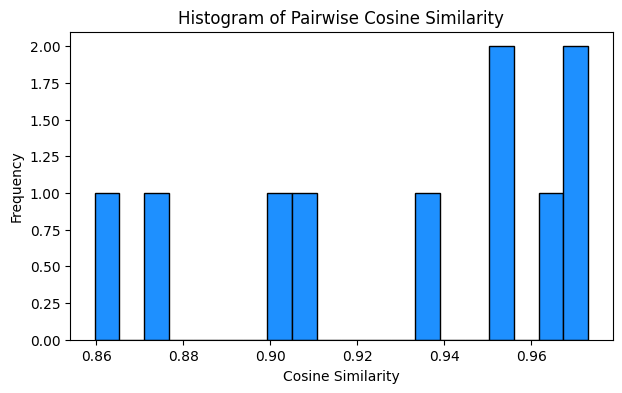

In [15]:
%matplotlib inline
import numpy as np

# Plotting setup for environments where some matplotlib backends may not work cleanly
import matplotlib
import sys
import os
import matplotlib.pyplot as plt

# Normalize the feature vectors
normed_features = l2_normalize(features)

# Compute cosine distances between all pairs using numpy broadcasting
cosine_similarity_matrix = np.dot(normed_features, normed_features.T)
triu_indices = np.triu_indices_from(cosine_similarity_matrix, k=1)
cosine_similarities = cosine_similarity_matrix[triu_indices]

# Plot histogram
plt.figure(figsize=(7,4))
plt.hist(cosine_similarities, bins=20, color='dodgerblue', edgecolor='black')
plt.title("Histogram of Pairwise Cosine Similarity")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()